# Modélisation avec Random Forest

In [1]:
conda install python-graphviz

Channels:
 - conda-forge
Platform: linux-64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
import fonctions as f

#Bibliothèques pour la visualisation des arbres
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import pandas as pd



In [3]:
#on divise la base en partie test et en partie entraînement
data= f.pd.read_csv("dataMod.csv", index_col =["DATE"])
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

# On divisie la base train en une partie contenant les variables explicatives et la variable d'interêt
x_train=train.drop('TM',axis=1)
TM_train=train['TM']
# On divisie la base test en une partie contenant les variables explicatives et la variable d'interêt
x_test=test.drop('TM',axis=1)
TM_test=test['TM']

In [27]:
x_train.shape,x_test.shape,TM_train.shape,TM_test.shape

((817, 29), (205, 29), (817,), (205,))

In [5]:
#recherche des meilleurs paramètres 
param_dist = {'n_estimators': randint(50,500),# il s’agit du nombre d’arbres dans la forêt
              'max_depth': randint(1,20)}#il s’agit de la profondeur maximale des arbres utilisés (le nombre de niveaux dans l’arbre de décision)

# Creation d'un random forest classifier
rf = RandomForestRegressor()

# Utilisation de random search pour trouver les meilleurs paramètres
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(x_train, TM_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7feb7cf00f20>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7feb7cf01eb0>})

In [6]:
# Création d'une variable pour le meilleur modèle
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 11, 'n_estimators': 285}


In [7]:
#On réalise ainsi la regression
rf=RandomForestRegressor(max_depth=19, n_estimators=258)
rf.fit(x_train, TM_train)

RandomForestRegressor(max_depth=19, n_estimators=258)

# Future Importance
On peut afficher l’importance des variables de notre modèle de forêt aléatoire :

In [8]:
f.pd.DataFrame(rf.feature_importances_,
              index = x_train.columns, 
              columns = ["importance"]).sort_values(
     "importance", 
     ascending = False)

,importance
TMNX,0.606103
TNTXM,0.347057
DG,0.015519
TX,0.011639
DHUMI80,0.003557
TSVM,0.003482
UM,0.001844
ETPGRILLE,0.001090
TN,0.000948
FFM,0.000880


Text(0.5, 1.0, 'Variable Importances')

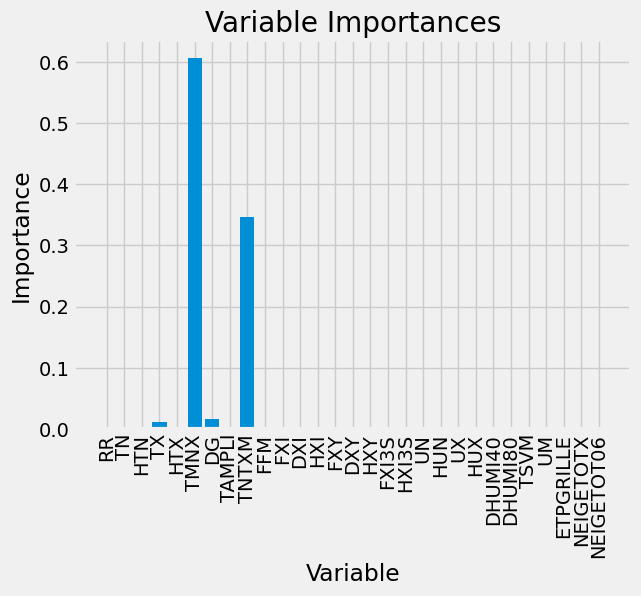

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

importances = list(rf.feature_importances_)
feature_list = list(x_train.columns)

# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

# mettre signification
On voit que la variable les plus importantes  sont  TMNX et TNTXM. On voit que la moins importante est NEIGTOT06

In [10]:
import io
from sklearn.tree import export_graphviz
import graphviz
from six import StringIO  
import pydotplus

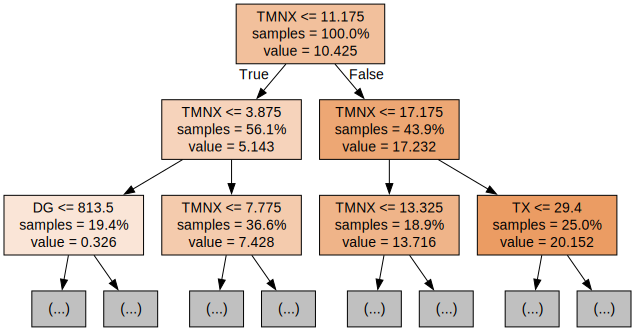

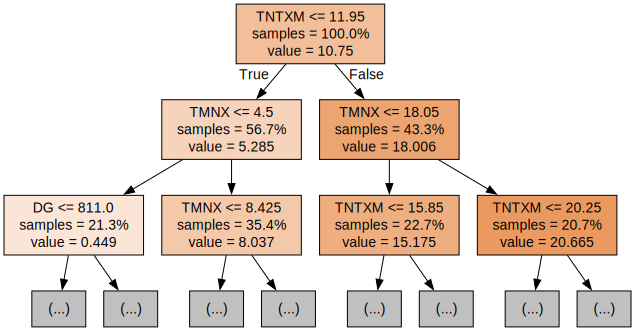

In [11]:
#Visualisation des 2 premiers arbres
for i in range(2):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=x_train.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)





# Prévision

In [12]:
import numpy as np

predict=rf.predict(x_test)
# Calculate the absolute errors
errors = abs(predict - TM_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.63 degrees.


# Détermination des métriques de Performance

In [13]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.metrics import mean_absolute_error


print('Mean Absolute Error:',mean_absolute_error(TM_test, predict))

mape = mean_absolute_percentage_error(TM_test, predict) * 100

# Calcul de R²
r2 = r2_score(TM_test, predict)

print(f"MAPE: {mape}%")
print(f"R²: {r2}")


Mean Absolute Error: 0.6314785403667997
MAPE: 5.0225981778998525%
R²: 0.9723255098601913


In [24]:
# On ajoute les dates aux prédictions
predict_data= pd.DataFrame(data = {'date': TM_test.index, 'prediction': predict})
predict_data.head()

,date,prediction
0,2024-04-10,7.636434
1,2024-04-11,8.682946
2,2024-04-12,11.298837
3,2024-04-13,14.489147
4,2024-04-14,15.570543


Text(0.5, 1.0, 'Actual and Predicted Values')

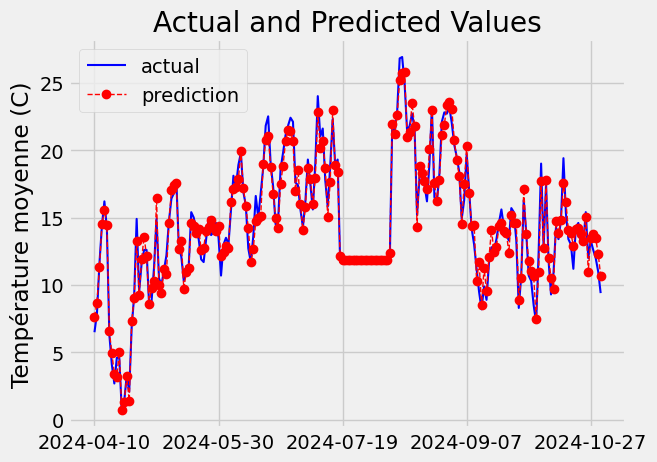

In [26]:
from matplotlib.ticker import MaxNLocator
#plot des vraies valeurs
#
plt.plot(TM_test.index, TM_test, 'b-',linewidth=1.5, label = 'actual')


# Plot the predicted values
plt.plot(predict_data['date'], predict_data['prediction'], 'ro',linestyle="--", linewidth=1, label = 'prediction')
# Limiter le nombre de ticks à 5 maximum
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=5))
#plt.xticks(rotation="vertical") 
plt.legend()
# Graph labels
plt.ylabel('Température moyenne (C)')
plt.title('Actual and Predicted Values')




# Random Forest sans TNMX et TMTNX


In [ ]:


x_train2=train.drop(columns=['TMNX', 'TNTXM','TM'])
TM_train=train['TM']
# On divisie la base test en une partie contenant les variables explicatives et la variable d'interêt
x_test2=test.drop(columns=['TMNX', 'TNTXM','TM'])
TM_test=test['TM']


In [9]:
#recherche des meilleurs paramètres 
param_dist = {'n_estimators': randint(50,500),# il s’agit du nombre d’arbres dans la forêt
              'max_depth': randint(1,20)}#il s’agit de la profondeur maximale des arbres utilisés (le nombre de niveaux dans l’arbre de décision)

# Creation d'un random forest classifier
rf = RandomForestRegressor()

# Utilisation de random search pour trouver les meilleurs paramètres
rand_search = RandomizedSearchCV(rf,
                                 param_distributions = param_dist,
                                 n_iter=5,
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(x_train2, TM_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f31c360f320>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f2d63d0df70>})

In [12]:
# Création d'une variable pour le meilleur modèle
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 16, 'n_estimators': 427}


In [14]:
#On réalise ainsi la regression
rf2=RandomForestRegressor(max_depth=16, n_estimators=427)
rf2.fit(x_train2, TM_train)

RandomForestRegressor(max_depth=16, n_estimators=427)

# Future importance

In [15]:
f.pd.DataFrame(rf2.feature_importances_,
              index = x_train2.columns, 
              columns = ["importance"]).sort_values(
     "importance", 
     ascending = False)

,importance
TX,0.725462
DG,0.113798
TSVM,0.105572
TN,0.033736
ETPGRILLE,0.006551
DHUMI80,0.002623
UM,0.001984
FFM,0.001036
FXI,0.000756
HUX,0.000696


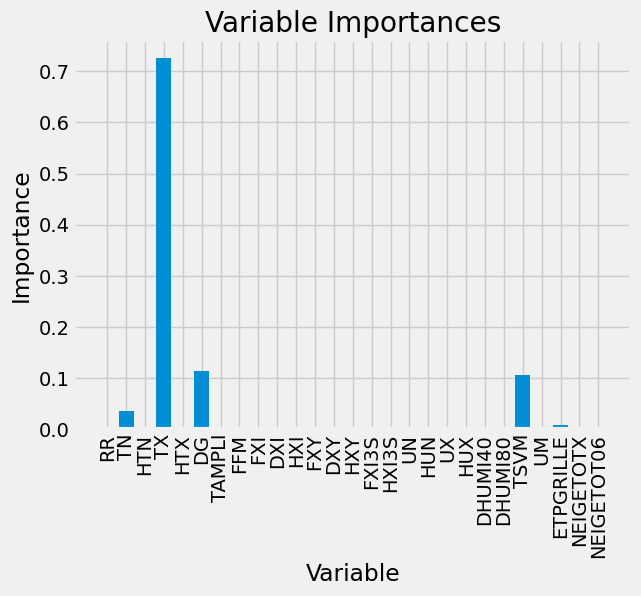

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

importances = list(rf2.feature_importances_)
feature_list = list(x_train2.columns)

# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

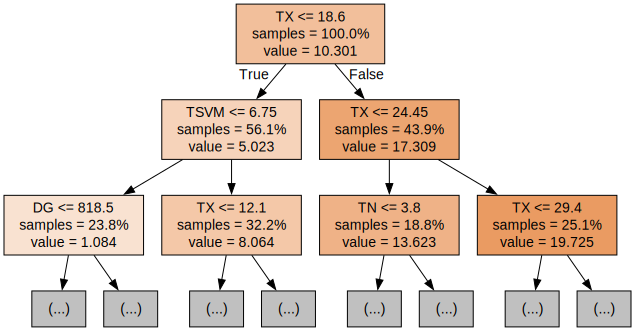

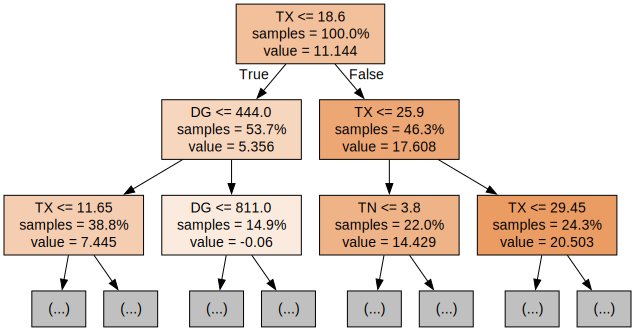

In [17]:
#Visualisation des 2 premiers arbres
for i in range(2):
    tree = rf2.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=x_train2.columns,
                               filled=True,
                               max_depth=2,
                               impurity=False,
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [18]:
import numpy as np

predict=rf2.predict(x_test2)
# Calculate the absolute errors
errors = abs(predict - TM_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.73 degrees.


# Evaluation du modèle

In [19]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.metrics import mean_absolute_error


print('Mean Absolute Error:',mean_absolute_error(TM_test, predict))

mape = mean_absolute_percentage_error(TM_test, predict) * 100

# Calcul de R²
r2 = r2_score(TM_test, predict)

print(f"MAPE: {mape}%")
print(f"R²: {r2}")

Mean Absolute Error: 0.7321131196285403
MAPE: 5.85630301832902%
R²: 0.9513942352595114


In [20]:
# On ajoute les dates aux prédictions
predict_data= pd.DataFrame(data = {'date': TM_test.index, 'prediction': predict})
predict_data.head()

,date,prediction
0,2024-04-10,7.827213
1,2024-04-11,7.777283
2,2024-04-12,11.351288
3,2024-04-13,16.028337
4,2024-04-14,16.913732


Text(0.5, 1.0, 'Actual and Predicted Values')

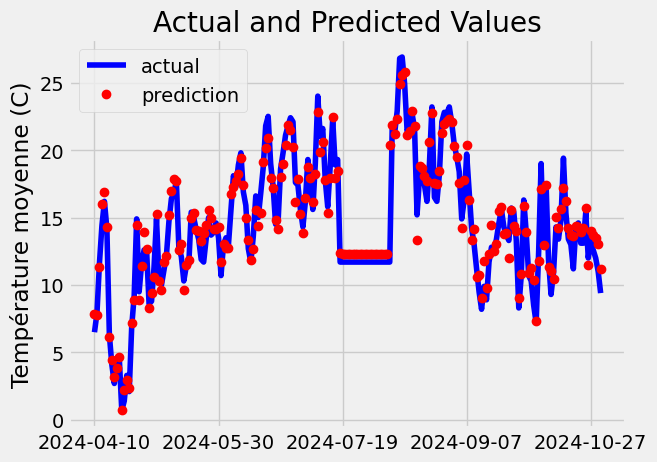

In [21]:
from matplotlib.ticker import MaxNLocator
#plot des vraies valeurs
#
plt.plot(TM_test.index, TM_test, 'b-', label = 'actual')


# Plot the predicted values
plt.plot(predict_data['date'], predict_data['prediction'], 'ro', label = 'prediction')
# Limiter le nombre de ticks à 5 maximum
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=5))
#plt.xticks(rotation="vertical") 
plt.legend()
# Graph labels
plt.ylabel('Température moyenne (C)')
plt.title('Actual and Predicted Values')